<a href="https://colab.research.google.com/github/Albertus-surya/DDC-Classification-using-Ensemble-Learning/blob/main/DDC_Classification_using_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: RoBERTa + BERT + DistilBERT

Strategy: Simple Average Ensemble

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, DataCollatorWithPadding)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

DATA LOADING AND PREPROCESSING

In [ ]:
print("DATA LOADING")

# Load dataset
filename = "dataset_ready_bolo.csv"
df = pd.read_csv(filename)

# Feature engineering: emphasize title by duplication
df['text'] = (df['judul_buku'].astype(str) + " " +
              df['judul_buku'].astype(str) + " " +
              df['deskripsi'].astype(str))

# Label mapping: DDC main classes to numeric labels
label_map = {0:0, 100:1, 200:2, 300:3, 400:4, 500:5, 600:6, 700:7, 800:8, 900:9}
df['label'] = df['main_class'].map(label_map).astype(int)

print(f"Total samples: {len(df)}")
print("\nClass distribution:")
print(df['label'].value_counts().sort_index())

# Train/validation split with stratification
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

# Handle class imbalance using oversampling
balanced_dfs = []
target_samples = 400

for label in range(10):
    class_df = train_df[train_df['label'] == label]
    if len(class_df) < target_samples:
        class_df = resample(
            class_df, n_samples=target_samples,
            random_state=42, replace=True
        )
    balanced_dfs.append(class_df)

train_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


DATA LOADING
Total samples: 16777

Class distribution:
label
0    1179
1    1095
2    1882
3    2000
4     621
5    2000
6    2000
7    2000
8    2000
9    2000
Name: count, dtype: int64

Training samples: 13421
Validation samples: 3356


MODEL TRAINING

In [ ]:
print("ENSEMBLE MODEL TRAINING")


# Model configurations
models_config = [
    ("roberta-base", "roberta", 2e-5, 6),
    ("bert-base-uncased", "bert", 2e-5, 6),
    ("distilbert-base-uncased", "distilbert", 3e-5, 5)
]

def compute_metrics(eval_pred):
    """Calculate accuracy for model evaluation"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Storage for ensemble predictions
all_logits = []
all_predictions = []
model_names = []
individual_accuracies = []

# Train each model in the ensemble
for model_name, short_name, learning_rate, num_epochs in models_config:
    print(f"Training Model: {short_name.upper()}")

    start_time = time()

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=256
        )

    # Tokenize datasets
    print("Tokenizing training data...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    print("Tokenizing validation data...")
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    # Load pre-trained model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=10
    ).to(device)

    # Training configuration
    training_args = TrainingArguments(
        output_dir=f"./ensemble_{short_name}",
        learning_rate=learning_rate,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        warmup_ratio=0.1,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        fp16=True,
        gradient_accumulation_steps=4,
        logging_steps=100,
        report_to="none",
        save_total_limit=1,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

    # Train model
    print(f"Training {short_name}...")
    trainer.train()

    # Evaluate model
    print(f"Evaluating {short_name}...")
    preds_output = trainer.predict(tokenized_val)
    logits = preds_output.predictions
    predictions = np.argmax(logits, axis=1)

    # Calculate individual accuracy
    individual_acc = accuracy_score(preds_output.label_ids, predictions)
    individual_accuracies.append(individual_acc)

    elapsed_time = time() - start_time
    print(f"Accuracy: {individual_acc:.4f}")
    print(f"Training time: {elapsed_time/60:.1f} minutes")

    # Store results
    all_logits.append(logits)
    all_predictions.append(predictions)
    model_names.append(short_name)

    # Save trained model
    save_path = f"./model_{short_name}_ensemble"
    trainer.save_model(save_path)
    print(f"Model saved: {save_path}")

ENSEMBLE MODEL TRAINING
Training Model: ROBERTA
Tokenizing training data...


Map:   0%|          | 0/13421 [00:00<?, ? examples/s]

Tokenizing validation data...


Map:   0%|          | 0/3356 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3627819062.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training roberta...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.873200,0.804131,0.738379
2,0.607000,0.711123,0.774732
3,0.436900,0.711944,0.783075
4,0.314500,0.753260,0.783969
5,0.218200,0.846051,0.779797
6,0.156700,0.867931,0.781287


Evaluating roberta...


Accuracy: 0.7840
Training time: 25.7 minutes
Model saved: ./model_roberta_ensemble
Training Model: BERT
Tokenizing training data...


Map:   0%|          | 0/13421 [00:00<?, ? examples/s]

Tokenizing validation data...


Map:   0%|          | 0/3356 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3627819062.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training bert...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.898300,0.806774,0.750894
2,0.603000,0.728718,0.770858
3,0.373700,0.739371,0.785459
4,0.242400,0.824914,0.780691
5,0.165000,0.899757,0.779499
6,0.099000,0.921367,0.778903


Evaluating bert...


Accuracy: 0.7855
Training time: 25.6 minutes
Model saved: ./model_bert_ensemble
Training Model: DISTILBERT
Tokenizing training data...


Map:   0%|          | 0/13421 [00:00<?, ? examples/s]

Tokenizing validation data...


Map:   0%|          | 0/3356 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3627819062.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training distilbert...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.899500,0.782154,0.756257
2,0.575600,0.770215,0.764303
3,0.377200,0.775077,0.769964
4,0.240300,0.847708,0.774434
5,0.169400,0.891242,0.769070


Evaluating distilbert...


Accuracy: 0.7744
Training time: 11.8 minutes
Model saved: ./model_distilbert_ensemble


ENSEMBLE PREDICTION

In [ ]:
print("ENSEMBLE STRATEGY: SIMPLE AVERAGE")

all_logits = np.array(all_logits)
y_true = preds_output.label_ids

print(f"Ensemble shape: {all_logits.shape}")
print(f"Models included: {', '.join(model_names)}")
print(f"\nIndividual model accuracies:")
for name, acc in zip(model_names, individual_accuracies):
    print(f"  {name:12s}: {acc:.4f}")

# Simple Average: Average logits across all models
avg_logits = np.mean(all_logits, axis=0)
ensemble_predictions = np.argmax(avg_logits, axis=1)
ensemble_accuracy = accuracy_score(y_true, ensemble_predictions)

print(f"\nEnsemble accuracy: {ensemble_accuracy:.4f}")
print(f"Improvement over best single model: +{(ensemble_accuracy - max(individual_accuracies)):.4f}")

ENSEMBLE STRATEGY: SIMPLE AVERAGE
Ensemble shape: (3, 3356, 10)
Models included: roberta, bert, distilbert

Individual model accuracies:
  roberta     : 0.7840
  bert        : 0.7855
  distilbert  : 0.7744

Ensemble accuracy: 0.7935
Improvement over best single model: +0.0080


EVALUATION

DETAILED EVALUATION

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       236
         100       0.75      0.75      0.75       219
         200       0.86      0.92      0.88       377
         300       0.68      0.69      0.69       400
         400       0.81      0.80      0.80       124
         500       0.88      0.86      0.87       400
         600       0.78      0.73      0.75       400
         700       0.80      0.81      0.80       400
         800       0.81      0.85      0.83       400
         900       0.82      0.76      0.79       400

    accuracy                           0.79      3356
   macro avg       0.79      0.79      0.79      3356
weighted avg       0.79      0.79      0.79      3356


Confusion matrix saved: confusion_matrix_ensemble.png
PER-CLASS PERFORMANCE
Class      Precision    Recall       F1-Score     Support   
0          0.7195      0.7500      0.7344      236
100     

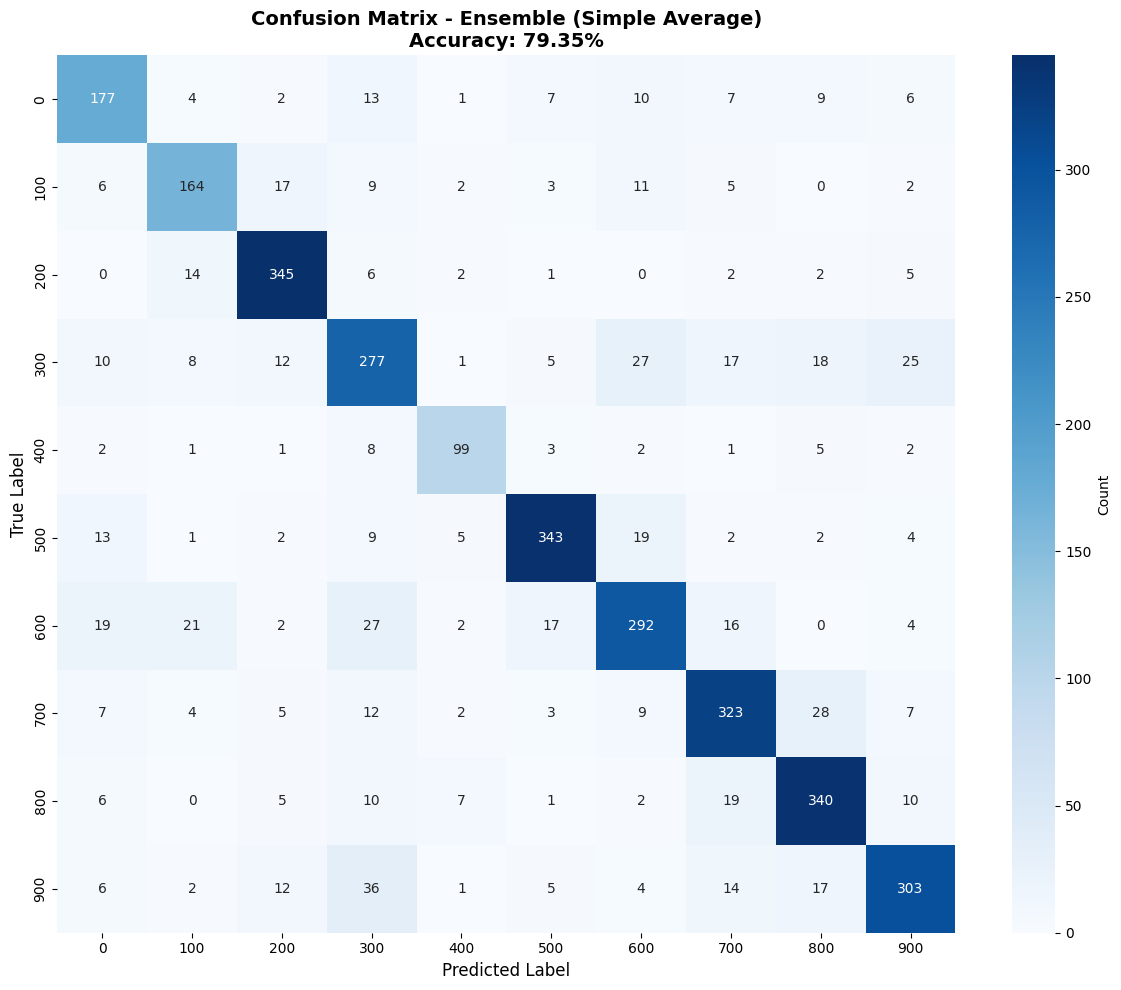

In [ ]:
print("DETAILED EVALUATION")

# Map predictions back to original DDC labels
reverse_map = {v: k for k, v in label_map.items()}
y_pred_mapped = [reverse_map[y] for y in ensemble_predictions]
y_true_mapped = [reverse_map[y] for y in y_true]

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_mapped, y_pred_mapped, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true_mapped, y_pred_mapped)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=sorted(label_map.keys()),
    yticklabels=sorted(label_map.keys()),
    cbar_kws={'label': 'Count'}
)
plt.title(
    f'Confusion Matrix - Ensemble (Simple Average)\nAccuracy: {ensemble_accuracy:.2%}',
    fontsize=14, fontweight='bold'
)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_ensemble.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved: confusion_matrix_ensemble.png")

# Per-class performance analysis
print("PER-CLASS PERFORMANCE")
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")

report_dict = classification_report(y_true_mapped, y_pred_mapped, output_dict=True, zero_division=0)
for label in sorted(label_map.keys()):
    label_str = str(label)
    if label_str in report_dict:
        metrics = report_dict[label_str]
        print(f"{label:<10} {metrics['precision']:.4f}      {metrics['recall']:.4f}      "
              f"{metrics['f1-score']:.4f}      {int(metrics['support'])}")

# Performance comparison
print("PERFORMANCE COMPARISON")
print(f"{'Model':<30} {'Accuracy':<12}")
for name, acc in zip(model_names, individual_accuracies):
    print(f"{name.capitalize() + ' (Individual)':<30} {acc:.2%}")
print(f"{'Ensemble (Simple Average)':<30} {ensemble_accuracy:.2%}")
improvement = (ensemble_accuracy - 0.66) * 100